<a href="https://colab.research.google.com/github/adamserag1/Interpretability-for-VRDU-models/blob/main/Interpretability%20Exp/lime%20(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
'''
Get prediction from pretrained RVL-CDIP model
- load model
- load image
- preprocess image
- get prediction

perform lime on sample for each modality
display
'''

'\nGet prediction from pretrained RVL-CDIP model\n- load model\n- load image\n- preprocess image\n- get prediction\n\nperform lime on sample for each modality\ndisplay\n'

In [2]:
pip install -U datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 33.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 18.9 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
  Attempting uninstall: datasets
    Found existing installation: datasets 2.14.4
    Uninstalling datasets-2.14.4:
      Successfully uninstalled datasets-2.14.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-cupti-cu12

In [3]:
!pip install datasets seqeval evaluate transformers torch pytesseract lime scikit-image

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 3.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 26.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 124.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 92.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 61.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 41.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 20.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [4]:
from PIL import Image, ImageDraw, ImageFont
import evaluate
from transformers import AutoProcessor, LayoutLMv3ForSequenceClassification, set_seed
from datasets import load_dataset
import transformers as t
import torch
import pandas as pd

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


set_seed(0)

In [5]:
model = LayoutLMv3ForSequenceClassification.from_pretrained("gordonlim/layoutlmv3-base-finetuned-rvlcdip").to(device)
processor = AutoProcessor.from_pretrained("microsoft/layoutlmv3-base", apply_ocr=False)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/504M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/275 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/856 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

In [6]:
# pip install -U datasets
mini_rvl   = load_dataset(
    "dvgodoy/rvl_cdip_mini", split="validation"
)

class_names = {'0': 'letter',
            '1': 'form',
            '2': 'email',
            '3': 'handwritten',
            '4': 'advertisement',
            '5': 'scientific report',
            '6': 'scientific publication',
            '7': 'specification',
            '8': 'file folder',
            '9': 'news article',
            '10': 'budget',
            '11': 'invoice',
            '12': 'presentation',
            '13': 'questionnaire',
            '14': 'resume',
            '15': 'memo'}

README.md: 0.00B [00:00, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/341M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/42.4M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/41.5M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/3200 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/400 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/400 [00:00<?, ? examples/s]

dict_keys(['image', 'width', 'height', 'category', 'ocr_words', 'word_boxes', 'ocr_paragraphs', 'paragraph_boxes', 'label'])
1
['Xlkoros', 'BOOTH TEST DATA', 'ZE', 'SUMMARY SHEET', 'WNLtA', '305', 'PROJECT NO.', 'ouy', 'XEMCEL&"ZHo', 'flbnLEl', 'AxiLa', 'TITLE:', 'TyLEEE Eutux Ae{Eacs', '&Au', '%LuclaxhLL', 'DA', 'Ouihzi IILL', "YeadEster' k", '44', 'DATE;', 'Paired', 'comoirison', 'TEST METHOD: _', 'fIevor', 'deternine', 'differences', 'Scoke', 'PURPOSE:', 'PREPARATION;', 'Mukers', 'Apd_naer', 'Leduced Lghting', 'And_ahave_nrepardlloa L_', 'judges', 'PROCEOURE:', 'Walng', 'HGIL', 'Lion', 'Then', 'ney', 'insvered', '5amd| E $', 'ba/&nced', 'oresenta', 'the', 'Vions', 'the', 'ched', 'ba]lot', 'auts', 'X6D4ET', '2_XLDJCE', 'NAUuui', 'RESULTS:', 'kuv', '1.u', 'Maul"', '412', 'a uilc_:LD', '21114', 'lLi LSLLi', 'Joa', 'LisL', '0402', '214', '44', 't', '~k', 'Fanul', 'CONCLUSIONS', 'Ouutl_Ac4LlE', 'Qul zk_"\' cigt:', 'X6D4LEJ T', 'tsl-', 'Jol', 'my', '#ouo(pton _', 'Llu _', 'Ilkzp)', '[', '

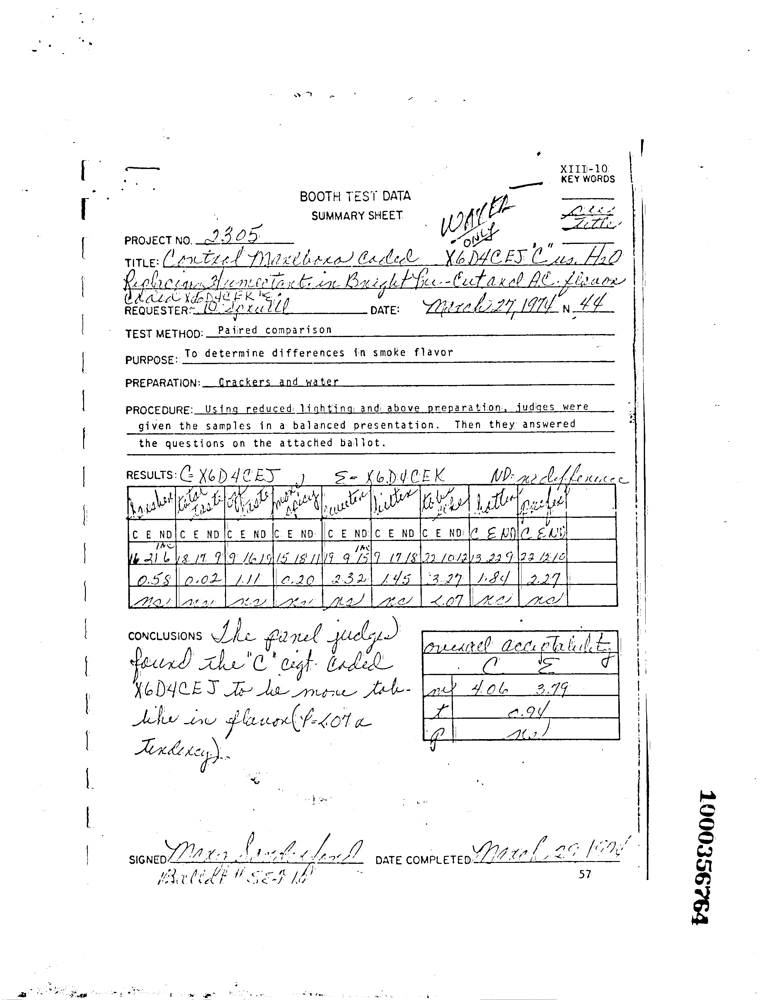

In [7]:
# Take sample from rvl
sample = mini_rvl[100] #104
image = sample['image'].convert("RGB")
words = sample['ocr_words']
bboxes = sample['word_boxes']
print(sample.keys())
print(sample['label'])
print(words)
sample['image']
# FORM

In [8]:
print(len(words))
print(bboxes)

87
[[556, 160, 620, 188], [299, 189, 413, 205], [558, 202, 620, 232], [311, 209, 405, 223], [427, 215, 526, 217], [220, 220, 264, 246], [122, 232, 193, 250], [457, 236, 503, 239], [440, 238, 626, 270], [246, 243, 422, 272], [174, 246, 234, 270], [125, 257, 161, 273], [339, 261, 629, 303], [119, 265, 215, 309], [209, 273, 343, 291], [197, 283, 295, 319], [418, 285, 563, 323], [122, 290, 208, 320], [574, 290, 612, 318], [369, 303, 403, 317], [217, 325, 261, 339], [266, 326, 332, 334], [125, 327, 207, 341], [413, 345, 457, 359], [203, 347, 265, 361], [271, 347, 347, 361], [372, 348, 406, 356], [125, 353, 181, 367], [125, 377, 203, 391], [217, 377, 273, 391], [277, 377, 341, 389], [245, 401, 355, 417], [359, 401, 509, 417], [513, 401, 557, 415], [125, 403, 197, 417], [203, 403, 241, 417], [562, 404, 588, 412], [407, 419, 437, 433], [454, 420, 482, 428], [488, 420, 516, 428], [524, 420, 576, 428], [206, 422, 250, 430], [292, 422, 346, 430], [354, 422, 406, 430], [137, 437, 161, 451], [193, 

In [9]:
# Pass sample through model

# Logit with no perturbations => 0.9538

# words = ['UNK' for i in words]
# bboxes = [[0,0,0,0] for i in bboxes]
inputs = processor(images=[image], text=[words],boxes=[bboxes], return_tensors="pt")
inputs.to(device)

with torch.no_grad():
    outputs = model(**inputs)
logits = outputs.logits
print(logits)
predicted_class_id = logits.argmax(-1).item()
gt = sample['label']
print(f'pred -> {model.config.id2label[predicted_class_id]} actual -> {gt}')
model.config.id2label[predicted_class_id]

/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:1614: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


tensor([[-0.9538,  7.3849, -2.4934, -1.7242, -2.2957,  5.2018, -0.5007, -0.5510,
         -0.2103, -2.0204, -1.0210, -0.6517, -0.3231,  0.0479, -1.1607, -0.4476]],
       device='cuda:0')
pred -> LABEL_1 actual -> 1


'LABEL_1'

In [10]:
print(logits)

tensor([[-0.9538,  7.3849, -2.4934, -1.7242, -2.2957,  5.2018, -0.5007, -0.5510,
         -0.2103, -2.0204, -1.0210, -0.6517, -0.3231,  0.0479, -1.1607, -0.4476]],
       device='cuda:0')


##Text modality

When perturbing text it is important to remeber that vision and layout components must be perturbed aswell, so that the model does not infer the presence of any text

In [11]:
from lime.lime_tabular import LimeTabularExplainer
from tqdm import tqdm
import numpy as np

def make_predict_fn(model, image, boxes, words, tokenizer):
    def predict(z_bin_list):
        outputs = []
        for z_bin in tqdm(z_bin_list, desc="Perturbing and Predicting"):
            # Masked words → UNK or garbage string
            perturbed_words = [
                word if z else "[UNK]"
                for word, z in zip(words, z_bin)
            ]
            # Masked boxes → zero box
            perturbed_boxes = [
                box if z else [0, 0, 0, 0]
                for box, z in zip(boxes, z_bin)
            ]
            encoding = tokenizer(
                text=[perturbed_words],
                boxes=[perturbed_boxes],
                images=[image],
                return_tensors="pt",
                padding="max_length",
                truncation=True,
                max_length=128,
            )
            encoding = {k: v.to(device) for k, v in encoding.items()}
            with torch.no_grad():
                logits = model(**encoding).logits
                probs = torch.softmax(logits, dim=-1).cpu().numpy()
                outputs.append(probs[0])
        return np.array(outputs)
    return predict

num_tokens = len(words)

# Explainer
explainer = LimeTabularExplainer(
    training_data=np.vstack([np.ones(num_tokens), np.zeros(num_tokens)]),   # reference distribution to sample pertubed versions of input
    feature_names=words,                      # each word is a named feature
    class_names=[model.config.id2label[i] for i in range(model.config.num_labels)],
    discretize_continuous=False,
    categorical_features=list(range(num_tokens)),
    mode="classification",
    kernel_width=np.sqrt(num_tokens)
)

predict_fn = make_predict_fn(model, image, bboxes, words, processor)

# Explain the instance: we use a vector of all 1s (keep all words) as the reference
explanation = explainer.explain_instance(
    data_row=np.ones(num_tokens),         # interpretability vector
    predict_fn=predict_fn,
    num_features=30,
    num_samples=4000
)

Perturbing and Predicting:   0%|          | 0/4000 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:1614: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
Perturbing and Predicting: 100%|██████████| 4000/4000 [02:18<00:00, 28.81it/s]


In [12]:
weights_dict = dict(explanation.as_list())
print("Explanation score (R²):", explanation.score)
for word, weight in explanation.as_list():
  print(f"{word:10s} -> {weight:+.3f}")

Explanation score (R²): 0.40419202567630974
SUMMARY SHEET=1 -> +0.054
TITLE:=1   -> +0.046
PROJECT NO.=1 -> +0.044
BOOTH TEST DATA=1 -> -0.029
DATE;=1    -> +0.028
PREPARATION;=1 -> -0.018
Paired=1   -> -0.009
PURPOSE:=1 -> +0.009
TEST METHOD: _=1 -> +0.007
differences=1 -> -0.007
Leduced Lghting=1 -> -0.006
305=1      -> +0.006
44=1       -> +0.005
flbnLEl=1  -> -0.005
deternine=1 -> +0.004
Ouihzi IILL=1 -> -0.004
WNLtA=1    -> +0.004
judges=1   -> +0.004
DA=1       -> +0.004
Qul zk_"' cigt:=1 -> +0.003
comoirison=1 -> +0.003
my=1       -> -0.003
Llu _=1    -> +0.003
Joa=1      -> +0.003
%LuclaxhLL=1 -> -0.003
ouy=1      -> -0.003
AxiLa=1    -> +0.003
XEMCEL&"ZHo=1 -> +0.003
DATE CCMPLETED=1 -> -0.003
PROCEOURE:=1 -> -0.002


/tmp/ipython-input-13-3672257016.py:43: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("coolwarm")


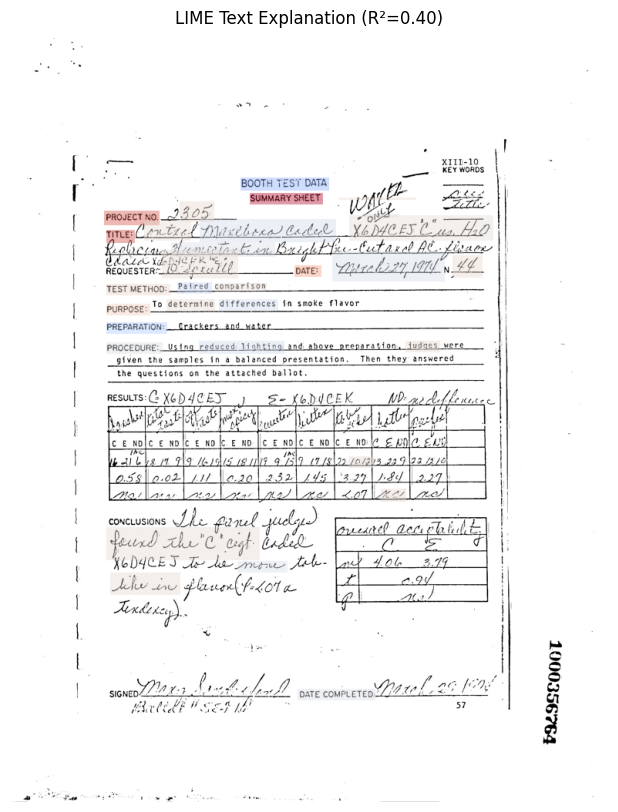

In [13]:
from PIL import ImageDraw, ImageFont
import matplotlib.pyplot as plt

weights_dict = {
    feature.split('=')[0].strip(): weight
    for feature, weight in explanation.as_list()
}

# def draw_lime_token_heatmap(image, words, boxes, weights_dict):
#     draw = ImageDraw.Draw(image)
#     max_weight = max(abs(w) for w in weights_dict.values()) or 1.0

#     for word, box in zip(words, boxes):
#         if word not in weights_dict:
#             continue
#         weight = weights_dict[word]
#         norm_weight = abs(weight) / max_weight
#         intensity = int(255 * norm_weight)

#         if weight > 0:
#             color = (255, 255 - intensity, 255 - intensity)  # bright red → pale red
#         else:
#             color = (255 - intensity, 255 - intensity, 255)  # bright blue → pale blue

#         draw.rectangle(box, outline=color, width=3)
#         #draw.text((box[0], box[1]), word, fill=color)

#     return image

from PIL import ImageDraw
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm

def draw_lime_token_heatmap(image, words, boxes, weights_dict, alpha=0.4):
    assert len(words) == len(boxes)

    draw = ImageDraw.Draw(image, mode="RGBA")
    all_weights = list(weights_dict.values())
    max_weight = max(abs(w) for w in all_weights) or 1.0

    # Diverging colormap (blue→white→red)
    cmap = cm.get_cmap("coolwarm")

    for word, box in zip(words, boxes):
        if word not in weights_dict:
            continue

        weight = weights_dict[word]
        norm_weight = weight / max_weight  # in [-1, 1]
        colour = cmap(0.5 + 0.5 * norm_weight)  # map to [0,1] for cmap

        rgba = tuple(int(255 * c) for c in colour[:3]) + (int(255 * alpha),)
        draw.rectangle(box, fill=rgba)

    return image

highlighted_image = draw_lime_token_heatmap(image.copy(), words, bboxes, weights_dict)

plt.figure(figsize=(12, 10))
plt.imshow(highlighted_image)
plt.axis('off')
plt.title(f"LIME Text Explanation (R²={explanation.score:.2f})")
plt.show()

##Vision Modality

In [14]:
from lime import lime_image
from skimage.segmentation import slic

def make_vision_predict_fn(model, processor, words, boxes, device):
    """
    Returns a function f(images) -> probs[n_images, n_classes]
    `images` is a list of HxWxC numpy arrays produced by LIME.
    """
    def predict_fn(image_list):
        # vectorised batch inference – no inner tqdm
        pil_imgs = [Image.fromarray(img) for img in image_list]
        enc = processor(
            images=pil_imgs,
            text=[words] * len(pil_imgs),
            boxes=[boxes] * len(pil_imgs),
            return_tensors="pt",
            padding="max_length",
            truncation=True,
            max_length=128,
        )
        enc = {k: v.to(device) for k, v in enc.items()}
        with torch.no_grad():
            logits = model(**enc).logits
            probs  = torch.softmax(logits, dim=-1).cpu().numpy()
        return probs
    return predict_fn

def slic_segmentation(img):
    return slic(img, n_segments=200, compactness=20, sigma=1, start_label=1)

explainer_img = lime_image.LimeImageExplainer(random_state=0)

predict_fn_img = make_vision_predict_fn(
    model, processor, words, bboxes, device
)

# LIME works best on smaller images; resize if >1 000 px on the long edge
h, w = image.height, image.width
if max(h, w) > 1000:
    print('Resized Image')
    image_small = image.resize((w//2, h//2))
else:
    image_small = image

explanation_img = explainer_img.explain_instance(
    np.array(image_small),
    classifier_fn=predict_fn_img,
    top_labels=1,
    hide_color=(127,127,127),   # neutral grey
    num_samples=8000,
    segmentation_fn=slic_segmentation,
    batch_size=50
)

  0%|          | 0/8000 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:1614: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


In [15]:
orig   = predict_fn_img([np.array(image_small)])[0][explanation_img.top_labels[0]]
blank  = predict_fn_img([np.full_like(np.array(image_small), 0)])[0][explanation_img.top_labels[0]]
print(f"Δ probability = {orig - blank:.3f}")

Δ probability = 0.292


/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:1614: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


0.4666865241985517


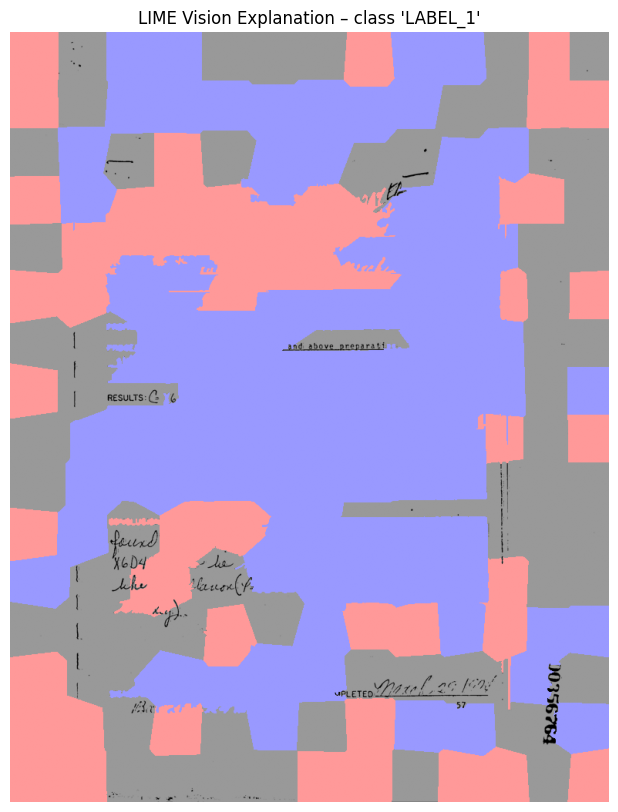

In [16]:
print(explanation_img.score)

from skimage.color import label2rgb
import matplotlib.pyplot as plt

# Get mask for the predicted class
pred_class = int(explanation_img.top_labels[0])
temp, mask = explanation_img.get_image_and_mask(
    label=pred_class,
    positive_only=False,    # show positive AND negative
    num_features=100,        # top-N super-pixels
    hide_rest=False         # keep full context
)

vis_image = label2rgb(mask, temp, bg_label=0, alpha=0.4)

plt.figure(figsize=(8,10))
plt.imshow(vis_image)
plt.axis('off')
plt.title(f"LIME Vision Explanation – class '{model.config.id2label[pred_class]}'")
plt.show()